# Getting started with AudioSeal

This notebook shows a minimal example to get started with AudioSeal. Make sure you install the package from PyPi or from source in editable mode beforehand.

First, let's prepare some example audios into the proper Tensor format using Torchaudio

In [1]:
%%capture

# For the demonstration, we need torchaudio and matplotlib to process example audios and visualize the spectrogram
import sys
!{sys.executable} -m pip install torchaudio soundfile matplotlib

In [1]:
import torch
import torchaudio
import urllib

def download_sample_audio():
    url = "https://keithito.com/LJ-Speech-Dataset/LJ037-0171.wav"
    with open("test.wav", "wb") as f:
        resp = urllib.request.urlopen(url)
        f.write(resp.read())
    
    wav, sample_rate = torchaudio.load("test.wav")
    return wav, sample_rate

audio, sr = download_sample_audio()

(Quick check of the original content and spectrogram)

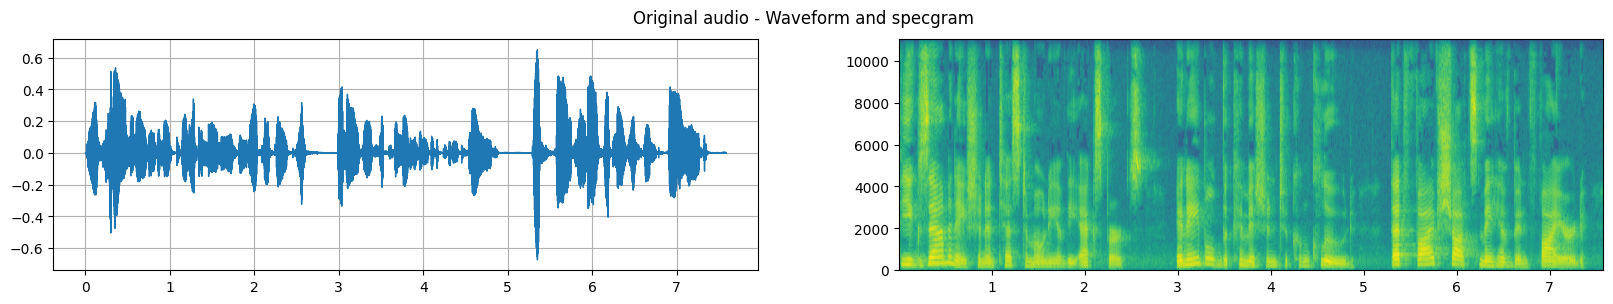

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

from notebook import play_audio, plot_waveform_and_specgram

plot_waveform_and_specgram(audio, sr, title="Original audio")

In [3]:
play_audio(audio, sr)

## Generator

To watermark an audio, we simply load the watermarking generator from the hub:

In [17]:

from audioseal import AudioSeal

model = AudioSeal.load_generator("audioseal_wm_16bits")

# We add the batch dimension to the single audio to mimic the batch watermarking
audios = audio.unsqueeze(0)

watermark = model.get_watermark(audios, sample_rate=sr)
watermarked_audio = audios + watermark

# Alternatively, you can also call forward() function directly with different tune-down / tune-up rate
watermarked_audio = model(audios, sample_rate=sr, alpha=1.)

We can see that the watermarked audio has preserved almost the same spectrogram and contents as the original one

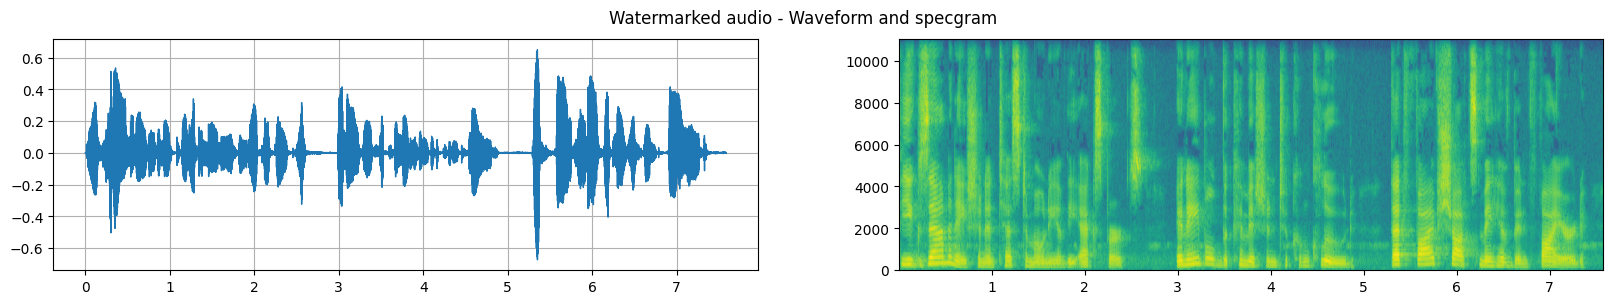

In [18]:
plot_waveform_and_specgram(watermarked_audio.squeeze(), sr, title="Watermarked audio")

In [19]:
play_audio(watermarked_audio, sr)

### Watermarking with a secret message:

AudioSeal uses a secret message to generate a watermarking, which consists of <i>n</i> binary bits (n=16 for the above model, hence the model name). By default, if the user does not specify these n bits, a random message will be generated. This can be customized either by assigning the secret message before the watermarking process:

```
`model.message = <n bit Tensor>`
``` 

or by executing the model each time with one explicit secret message:

```
watermark = model(audio, message=<message>)
```

In [20]:
secret_mesage = torch.randint(0, 2, (1, 16), dtype=torch.int32)
secret_mesage

tensor([[0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1]], dtype=torch.int32)

In [27]:
watermarked_audio = model(audios, sample_rate=16000, message=secret_mesage, alpha=1)

## Detector

To detect the watermarks from an audio, we load the separate detector model and can do one of the following:

### Basic usage: Call `detect_watermark()`
This results in a tuple of form `Tuple(float, Tensor)`, where the first value indicates the probability of the audio being watermarked (the higher, the more likely), and the second value is the decoded message that is embeded by the generator. If the audio is unwatermarked (low first value), the decoded message will be just some random bits.

Note that due to the stochastic nature of the detector, the decoded message and the secret message might miss by 1 bit, so depending on the user's need, the detection might be called multiple times to get an averaged decoded message.

In [29]:
detector = AudioSeal.load_detector(("audioseal_detector_16bits"))

result, message = detector.detect_watermark(watermarked_audio, sample_rate=16000, message_threshold=0.5)

print(f"\nThis is likely a watermarked audio: {result}")

# Run on an unwatermarked audio
result2, message2 = detector.detect_watermark(audios, sample_rate=sr, message_threshold=0.5)
print(f"This is likely an unwatermarked audio: {result2}")



This is likely a watermarked audio: 1.0
This is likely an unwatermarked audio: 3.296440627309494e-05


In [11]:
message

tensor([[1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0]], dtype=torch.int32)

`message_threshold` indicates the threshold in which the detector will convert the stochastic messages (with probability between 0 and 1) into the n-bit binary format. In most of the case, the generator generates an unbiased message from the secret, so `0.5` is a reasonable choice (so in the above example, value > 0.5 means 1 and value < 0.5 means 0). 


#### Advanced usage: Call `forward()`

The detector can also be called directly as a Torch module. This will return 2 tensors: 
- The first tensor of size `batch x 2 x frames` indicates the probability of each frame being watermarked (positive or negative). So t[:, 0, :] corresponds to the negative probability and t[:, 1, :] corresponds to the positive probability
- The second tensor of size `batch x n_bits` corresponds to the message detected from the audio. It indicates the probability for each bit to be 1. In case of unwatermarked audios, this tensor is random

In [12]:
pred_prob, message_prob = detector(watermarked_audio)
pred_prob[:, 1, :]

tensor([[0.9996, 0.9996, 0.9996,  ..., 0.9627, 0.9623, 0.9621]],
       grad_fn=<SliceBackward0>)

In [14]:
message_prob

tensor([[0.6847, 0.3179, 0.3687, 0.6794, 0.6262, 0.3439, 0.6959, 0.2580, 0.6924,
         0.3005, 0.5802, 0.6746, 0.2983, 0.6068, 0.3391, 0.4364]],
       grad_fn=<SigmoidBackward0>)

### Robustness against attacks

We can evaluate the robustness of the detector against some attacks. For this purpose, we will perform some simple attacks: Pink noise, highpass filter, compression in different formats. For the full list of attacks, please refer to our paper. 


#### Pink noise attack

In [15]:
from audioseal.attacks import AudioEffects as af

pink_noised_audio = af.pink_noise(watermarked_audio, noise_std=0.2)

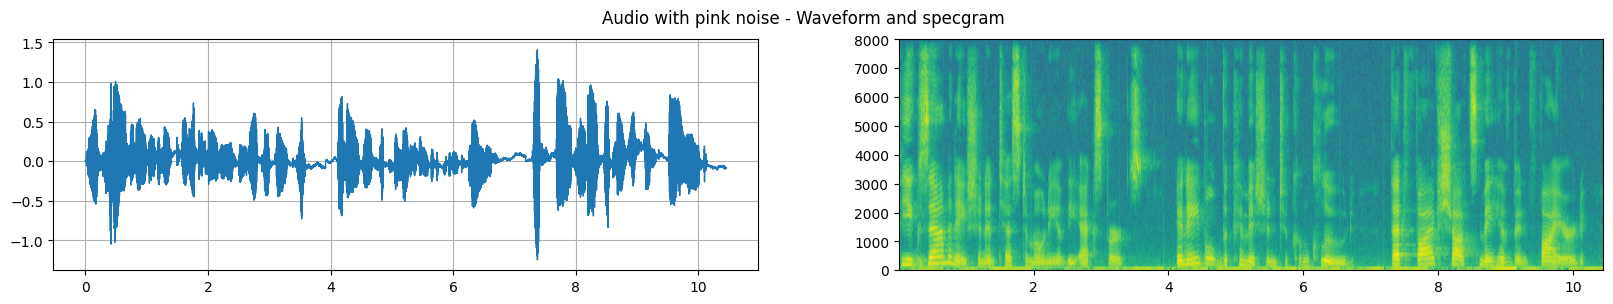

In [16]:
plot_waveform_and_specgram(pink_noised_audio, sample_rate=16000, title="Audio with pink noise")

In [17]:
result, message = detector.detect_watermark(pink_noised_audio)
result

0.8877208232879639

#### Lowpass filter

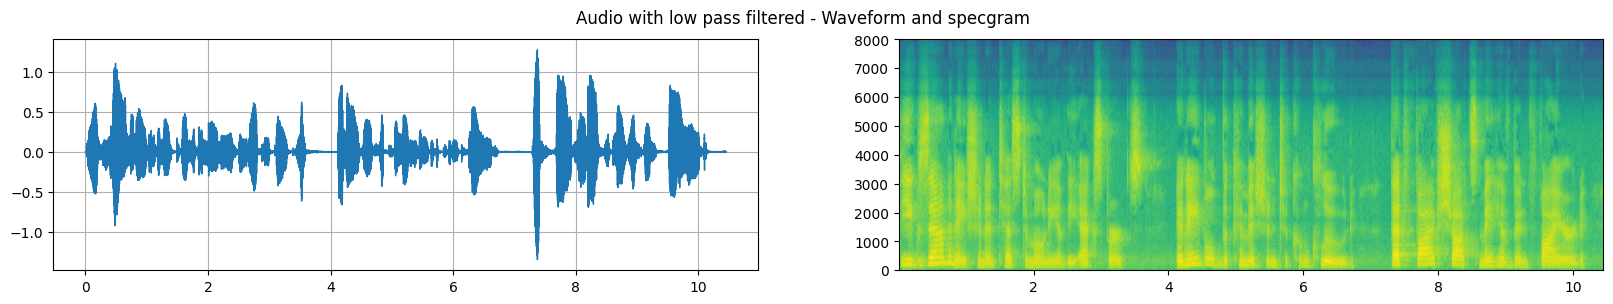

In [18]:
lowpass_filtered = af.lowpass_filter(watermarked_audio, cutoff_freq=5000, sample_rate=16000)
plot_waveform_and_specgram(lowpass_filtered, sample_rate=16000, title="Audio with low pass filtered")

In [20]:
result, message = detector.detect_watermark(lowpass_filtered)
result

0.9748304486274719